<h1>Geocoding Notebook - Bangladesh<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Packages-and-functions" data-toc-modified-id="Packages-and-functions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Packages and functions</a></span></li><li><span><a href="#Prepare-and-match-admin-boundary-data" data-toc-modified-id="Prepare-and-match-admin-boundary-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Prepare and match admin boundary data</a></span><ul class="toc-item"><li><span><a href="#Match-health-list-admin-names-to-shapefile-admin-names" data-toc-modified-id="Match-health-list-admin-names-to-shapefile-admin-names-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Match health list admin names to shapefile admin names</a></span><ul class="toc-item"><li><span><a href="#Match-orgunitlevel4-to-Geob-Adm-3" data-toc-modified-id="Match-orgunitlevel4-to-Geob-Adm-3-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Match orgunitlevel4 to Geob Adm 3</a></span></li><li><span><a href="#Match-orgunitlevel3-to-Geob-Adm-2" data-toc-modified-id="Match-orgunitlevel3-to-Geob-Adm-2-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Match orgunitlevel3 to Geob Adm 2</a></span></li><li><span><a href="#Match-orgunitlevel2-to-Geob-Adm-1" data-toc-modified-id="Match-orgunitlevel2-to-Geob-Adm-1-2.1.3"><span class="toc-item-num">2.1.3&nbsp;&nbsp;</span>Match orgunitlevel2 to Geob Adm 1</a></span></li></ul></li></ul></li><li><span><a href="#Match-to-locations-from-alternative-sources-based-on-facility-name" data-toc-modified-id="Match-to-locations-from-alternative-sources-based-on-facility-name-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Match to locations from alternative sources based on facility name</a></span><ul class="toc-item"><li><span><a href="#Health-Sites-IO" data-toc-modified-id="Health-Sites-IO-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Health Sites IO</a></span></li><li><span><a href="#Health-Sites-IO-using-orgunitlevel-5-name" data-toc-modified-id="Health-Sites-IO-using-orgunitlevel-5-name-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Health Sites IO using orgunitlevel 5 name</a></span></li></ul></li><li><span><a href="#Geocoding-with-APIs" data-toc-modified-id="Geocoding-with-APIs-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Geocoding with APIs</a></span><ul class="toc-item"><li><span><a href="#Facility-name-and-admin-3-names" data-toc-modified-id="Facility-name-and-admin-3-names-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Facility name and admin 3 names</a></span></li><li><span><a href="#Facility-name-and-admin-2-names" data-toc-modified-id="Facility-name-and-admin-2-names-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Facility name and admin 2 names</a></span></li><li><span><a href="#Facility-name-and-admin-1-names" data-toc-modified-id="Facility-name-and-admin-1-names-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Facility name and admin 1 names</a></span></li><li><span><a href="#Orgunitlevel5-names" data-toc-modified-id="Orgunitlevel5-names-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Orgunitlevel5 names</a></span></li><li><span><a href="#Orgunitlevel4-names" data-toc-modified-id="Orgunitlevel4-names-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Orgunitlevel4 names</a></span></li><li><span><a href="#Admin-3--and-admin-2-names" data-toc-modified-id="Admin-3--and-admin-2-names-4.6"><span class="toc-item-num">4.6&nbsp;&nbsp;</span>Admin 3  and admin 2 names</a></span></li><li><span><a href="#Admin-3--and-admin-1-names" data-toc-modified-id="Admin-3--and-admin-1-names-4.7"><span class="toc-item-num">4.7&nbsp;&nbsp;</span>Admin 3  and admin 1 names</a></span></li></ul></li><li><span><a href="#Map-and-save-results" data-toc-modified-id="Map-and-save-results-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Map and save results</a></span><ul class="toc-item"><li><span><a href="#Join-attributes-from-adminsitrative-polygons" data-toc-modified-id="Join-attributes-from-adminsitrative-polygons-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Join attributes from adminsitrative polygons</a></span></li></ul></li></ul></div>

Version: January 23, 2023

This notebook works with health facilities from the HMIS Database and attempts to geolocate them, by joining them to administrative shapefiles, other sources of geo-located health facilities, and running queries with geocoding APIs.

**Data Sources**
- Health facilities (hierarchy list)
- Geoboundaries (Adm1 through 4)
- FEWS Admin-2 boundaries (updated post 2017)
- Health Sites IO
- RHINoVision Master Facility List Decision Support System

# Packages and functions

In [1]:
import os, sys
import geopandas as gpd
import pandas as pd
from geopy.geocoders import GeoNames, Nominatim, Bing, GoogleV3
from shapely.geometry import Point
from tqdm import tqdm
from thefuzz import fuzz
from thefuzz import process
import matplotlib.pyplot as plt
from string import ascii_uppercase
import contextily as ctx
from os.path import join
from dotenv import load_dotenv, find_dotenv

In [2]:
def remove_words(data_frame, column_name, words_to_remove = ['community', 'clinic', 'centre', 'center', 'hospital', 'health', 'government']):
    """ Remove words from strings in a specified column
    
    Args:
        data_frame: Pandas data frame
        column_name: Column name to remove words from
        words_to_remove: List of words

    Returns:
        Removes words in place

    """
    for word in words_to_remove:
        data_frame[column_name] = data_frame[column_name].str.replace(word, "")
    data_frame[column_name] = data_frame[column_name].str.strip()
        
def report_geocoding(records):
    """ Report value counts and % from geocoding_method column.
    
    Args:
        records: Pandas data frame

    Returns:
        Table with count stats 
    """
    table = records[['NAME', 'geocoding_method']].groupby('geocoding_method').count().rename(columns={'NAME':'count'})
    table.loc[:, "pct"] = table/(table['count'].sum())
    table = table.style.format({
        'pct': '{:,.1%}'.format,
    })
    return(table)

def match_name(name, list_names, min_score=0):
    """ Uses fuzzy matching between one string and a list of candidate names.
    
    Args:
        name: string
        list_names: list of candidate names to match
        min_score: minimum score allowed

    Returns:
        Returns name with the highest match, and match score
        If no match is higher than min score, returns "" and -1
    """
    # -1 score incase we don't get any matches
    max_score = -1
    # Returning empty name for no match as well
    max_name = ""
    # Iterating over all names in the other
    for name2 in list_names:
        #Finding fuzzy match score
        score = fuzz.ratio(name, name2)
        # Checking if we are above our threshold and have a better score
        if (score > min_score) & (score > max_score):
            max_name = name2
            max_score = score
    return (max_name, max_score)

def match_to_closest(row, gdf, column='ADMIN2'):
    """ Spatial join using closest distance algorithm.
    
    Args:
        row: row from geo data frame
        gdf: gdf with attributes to join
        column: attribute to join

    Returns:
        Returns specified attribute of closest feature
    """
    distances = [row.geometry.distance(pol) for pol in gdf.geometry]
    min_id = np.argmin(distances)
    closest = gdf.iloc[min_id]
    return closest[column]

def run_geocoding(idx, row, master_table, admin_area, components, country_code):
    """
    Geocoding workflow to be applied to each row in a dataset
    
    Args:
        idx: index
        row: row with index and names to geocode
        master_table: master table to store results
        admin_area: gdf of admin area to ensure result falls within
        components: list of names of attributes to use in query
        country_code: two letter iso code
    
    Returns:
        Stores geocoding results in master_table object
    """
    admin_bounds = admin_area.bounds
    bb = [(admin_bounds.iloc[0].miny, admin_bounds.iloc[0].minx), (admin_bounds.iloc[0].maxy, admin_bounds.iloc[0].maxx)]
    method = ' and '.join(components)
    items = [row[item] for item in components]
    query = ', '.join(items)
    
    geocoding_result = None
    geocoding_method = "None"
    # Try Geocoding with OSM
    try:
        res = geolocator_osm.geocode(query, country_codes=country_code)
        # if within admin
        if admin_area.contains(Point(res.longitude,res.latitude)).values[0] == True:
            geocoding_result = res
            geocoding_method = f"{method} query OSM"
        else:
            raise Exception("OSM point not valid or not within polygon")
    except:
        # Try Geocoding with Bing Maps
        try:
            res = geolocator_bing.geocode(query)
            # if within admin
            if admin_area.contains(Point(res.longitude,res.latitude)).values[0] == True:
                geocoding_result = res
                geocoding_method = f"{method} query Bing"
            else:
                raise Exception("Bing point not valid or not within polygon")
        except:
            # Try Geocoding with Google
            try:
                res = geolocator_google.geocode(query = query, region = country_code, bounds = bb)
                if res:
                    # if within admin
                    if admin_area.contains(Point(res.longitude,res.latitude)).values[0] == True:
                        geocoding_result = res
                        geocoding_method = f"{method} query Google"
            except:
                raise Exception("Google point not valid or not within polygon")
    
    master_table.loc[idx, "geocoding_method"] = geocoding_method
    if geocoding_result:
        master_table.loc[idx, "longitude"] = res.longitude
        master_table.loc[idx, "latitude"] = res.latitude

In [3]:
iso3 = "BGD"
country = "Bangladesh"
input_dir = "/home/public/Data/PROJECTS/Health" 
output_dir = join(input_dir, "output", iso3)
# if not os.path.exists(out_folder):
#     os.mkdir(out_folder)

# Prepare and match admin boundary data 

In [4]:
geob4 = gpd.read_file(f"https://github.com/wmgeolab/geoBoundaries/raw/b7dd6a5/releaseData/gbOpen/{iso3}/ADM4/geoBoundaries-{iso3}-ADM4.geojson")
geob3 = gpd.read_file(f"https://github.com/wmgeolab/geoBoundaries/raw/b7dd6a5/releaseData/gbOpen/{iso3}/ADM3/geoBoundaries-{iso3}-ADM3.geojson")
geob2 = gpd.read_file(f"https://github.com/wmgeolab/geoBoundaries/raw/b7dd6a5/releaseData/gbOpen/{iso3}/ADM2/geoBoundaries-{iso3}-ADM2.geojson")
geob1 = gpd.read_file(f"https://github.com/wmgeolab/geoBoundaries/raw/b7dd6a5/releaseData/gbOpen/{iso3}/ADM1/geoBoundaries-{iso3}-ADM1.geojson")

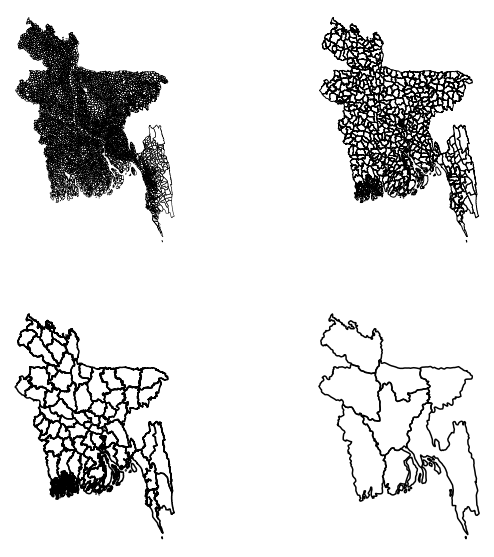

In [5]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))
geob4.boundary.plot(ax=ax[0, 0], color='black', linewidth=0.5).set_axis_off()
geob3.boundary.plot(ax=ax[0, 1], color='black', linewidth=1).set_axis_off()
geob2.boundary.plot(ax=ax[1, 0], color='black').set_axis_off()
geob1.boundary.plot(ax=ax[1, 1], color='black').set_axis_off()
# plt.axis('off')

In [6]:
master_table = pd.read_csv(os.path.join(input_dir, "tom_formatted", "hierarchy", "tom_edited_bangladesh_collapsed2.csv"), encoding='utf-8')

In [7]:
len(master_table)

20953

In [8]:
master_table.head(2)

,orgunitlevel1,orgunitlevel2,orgunitlevel3,orgunitlevel4,orgunitlevel5,orgunitlevel6,Unnamed: 6
0,Bangladesh,Barishal,Barguna,Amtali,AMTALI,Chalabhanga,NaN
1,Bangladesh,Barishal,Barguna,Amtali,AMTALI,Islampur,NaN


In [9]:
master_table = master_table.drop('Unnamed: 6', axis=1).copy()

In [10]:
master_table = master_table.dropna(axis=0, subset=['orgunitlevel6']).copy()

In [11]:
len(master_table)

13812

In [12]:
print(f"Unique Level 2: {len(master_table.orgunitlevel2.unique())}")
print(f"Unique Level 3: {len(master_table.orgunitlevel3.unique())}")
print(f"Unique Level 4: {len(master_table.orgunitlevel4.unique())}")
print(f"Unique Level 5: {len(master_table.orgunitlevel5.unique())}")

Unique Level 2: 8
Unique Level 3: 64
Unique Level 4: 484
Unique Level 5: 4065


In [13]:
print(f"Unique Geoboundaries Adm 1: {len(geob1)}")
print(f"Unique Geoboundaries Adm 2: {len(geob2)}")
print(f"Unique Geoboundaries Adm 3: {len(geob3)}")
print(f"Unique Geoboundaries Adm 4: {len(geob4)}")

Unique Geoboundaries Adm 1: 8
Unique Geoboundaries Adm 2: 64
Unique Geoboundaries Adm 3: 544
Unique Geoboundaries Adm 4: 5160


## Match health list admin names to shapefile admin names
### Match orgunitlevel4 to Geob Adm 3
Try using fuzzy matching  

In [14]:
level4_list = list(master_table.orgunitlevel4.unique())
level4_list.sort()
geob3_list = list(geob3.shapeName)
geob3_list.sort()

Print names to inspect

In [15]:
for letter in ascii_uppercase:
    level4_sublist = [name for name in level4_list if name[0]==letter]
    geob3_sublist = [name for name in geob3_list if name[0]==letter]

    if len(level4_sublist)>0:
        print("Master list level 4")
        print("\t"+str(level4_sublist))
    if len(geob3_sublist) >0:
        print("Geoboundaries adm3")
        print("\t"+str(geob3_sublist))
        
    print("\n")

Master list level 4
	['Abhaynagar ', 'Adamdighi ', 'Aditmari ', 'Agailjhara ', 'Ajmiriganj ', 'Akhaura ', 'Akkelpur ', 'Alamdanga ', 'Alfadanga ', 'Alikadam ', 'Amtali ', 'Anowara ', 'Araihazar ', 'Ashuganj ', 'Assasuni ', 'Atgharia ', 'Atowari ', 'Atpara ', 'Atrai ', 'Austagram ']
Geoboundaries adm3
	['Abhaynagar', 'Adabor', 'Adamdighi', 'Aditmari', 'Agailjhara', 'Ajmiriganj', 'Akhaura', 'Akkelpur', 'Alamdanga', 'Alfadanga', 'Alikadam', 'Amtali', 'Anowara', 'Araihazar', 'Ashuganj', 'Assasuni', 'Atgharia', 'Atpara', 'Atrai', 'Atwari', 'Austagram']


Master list level 4
	['Babuganj ', 'Badalgachhi ', 'Badarganj ', 'Bagatipara ', 'Bagerhat Sadar ', 'Bagha ', 'Baghai Chhari ', 'Bagherpara ', 'Baghmara ', 'Bahubal ', 'Bajitpur ', 'Bakerganj ', 'Bakshiganj ', 'Balaganj ', 'Baliadangi ', 'Baliakandi ', 'Bamna ', 'Banaripara ', 'Banchharampur ', 'Bandar ', 'Bandarban Sadar ', 'Baniachong ', 'Banshkhali ', 'Baraigram ', 'Barguna Sadar ', 'Barhatta ', 'Barisal Sadar ', 'Barkal ', 'Barlekha ', '

Manually adjust spellings of master health list to create more matches.

In [16]:
master_table.loc[:, "orgunitlevel4_edit"] = master_table.orgunitlevel4

Remove key words that confuse matching algorithm

In [17]:
remove_words(geob3, "shapeName", ['Town', 'City', 'Urban', 'Zone'])
remove_words(master_table, "orgunitlevel4_edit", ['Town', 'City', 'Urban', 'Zone'])

In [18]:
# level4_list = list(master_table.orgunitlevel4.unique())
level4_list = list(master_table.orgunitlevel4_edit.unique())
level4_list.sort()
geob3_list = list(geob3.shapeName)
geob3_list.sort()

In [19]:
# List for dicts for easy dataframe creation
dict_list = []
# iterating over our players without salaries found above
for name in level4_list:
    
    # Use our method to find best match, we can set a threshold here
    match = match_name(name, geob3_list, 30)

    # New dict for storing data
    dict_ = {}
    dict_.update({"name_level4" : name})
    dict_.update({"name_geob3" : match[0]})
    dict_.update({"score" : match[1]})
    dict_list.append(dict_)

table_adm3 = pd.DataFrame(dict_list)
table_adm3_matches = table_adm3[table_adm3.score >= 80].copy()

In [20]:
matches_pct = (len(table_adm3_matches) / len(level4_list))
'{:.2f}%'.format(matches_pct*100)

'97.11%'

In [21]:
# could save this list for someone to confirm matches manually
# for now take input noting which ones should be dropped based on quick inspection
table_adm3_matches.loc[table_adm3_matches.score<=80]

,name_level4,name_geob3,score
46,Barisal Sadar,Narail Sadar,80
158,Fultala,Phultala,80
193,Hijla,Hizla,80
215,Kachua BH,Kachua,80
216,Kachua CP,Kachua,80
353,Noakhali Sadar,Patuakhali Sadar,80


In [22]:
matches_pct = (len(table_adm3_matches) / len(level4_list))
'{:.2f}%'.format(matches_pct*100)

'97.11%'

### Match orgunitlevel3 to Geob Adm 2

In [23]:
master_table.loc[:, "orgunitlevel3_edit"] = master_table.orgunitlevel3

In [24]:
remove_words(geob2, "shapeName", [" City Council", " District Council", " Municipal Council"])
remove_words(master_table, "orgunitlevel3_edit", [" District"])

In [25]:
master_table.loc[master_table.orgunitlevel3_edit == "Chattogram", "orgunitlevel3_edit"] = "Chittagong"

In [26]:
level3_list = list(master_table.orgunitlevel3_edit.unique())
level3_list.sort()
geob2_list = list(geob2.shapeName)
geob2_list.sort()

In [27]:
for letter in ascii_uppercase:
    level3_sublist = [name for name in level3_list if name[0]==letter]
    geob2_sublist = [name for name in geob2_list if name[0]==letter]
    if len(level3_sublist)>0:
        print("Master list level 3")
        print("\t"+str(level3_sublist))
    if len(geob2_sublist) >0:
        print("Geoboundaries adm2")
        print("\t"+str(geob2_sublist))

Master list level 3
	['Bagerhat', 'Bandarban', 'Barguna', 'Barishal', 'Bhola', 'Bogura', 'Brahmanbaria']
Geoboundaries adm2
	['Bagerhat', 'Bandarban', 'Barguna', 'Barisal', 'Bhola', 'Bogra', 'Brahamanbaria']
Master list level 3
	['Chandpur', 'Chapai Nababganj', 'Chittagong', 'Chuadanga', 'Coxs Bazar', 'Cumilla']
Geoboundaries adm2
	['Chandpur', 'Chittagong', 'Chuadanga', 'Comilla', "Cox's Bazar"]
Master list level 3
	['Dhaka', 'Dinajpur']
Geoboundaries adm2
	['Dhaka', 'Dinajpur']
Master list level 3
	['Faridpur', 'Feni']
Geoboundaries adm2
	['Faridpur', 'Feni']
Master list level 3
	['Gaibandha', 'Gazipur', 'Gopalganj']
Geoboundaries adm2
	['Gaibandha', 'Gazipur', 'Gopalganj']
Master list level 3
	['Habiganj']
Geoboundaries adm2
	['Habiganj']
Master list level 3
	['Jamalpur', 'Jashore', 'Jhalokati', 'Jhenaidaha', 'Joypurhat']
Geoboundaries adm2
	['Jamalpur', 'Jessore', 'Jhalokati', 'Jhenaidah', 'Joypurhat']
Master list level 3
	['Khagrachhari', 'Khulna', 'Kishoreganj', 'Kurigram', 'Kust

In [28]:
# List for dicts for easy dataframe creation
dict_list = []
# iterating over our players without salaries found above
for name in level3_list:
    
    # Use our method to find best match, we can set a threshold here
    match = match_name(name, geob2_list, 30)

    # New dict for storing data
    dict_ = {}
    dict_.update({"name_level3" : name})
    dict_.update({"name_geob2" : match[0]})
    dict_.update({"score" : match[1]})
    dict_list.append(dict_)

table_adm2 = pd.DataFrame(dict_list)
table_adm2_matches = table_adm2[table_adm2.score >= 80]

In [29]:
matches_pct = (len(table_adm2_matches) / len(level3_list))
'{:.2f}%'.format(matches_pct*100)

'96.88%'

### Match orgunitlevel2 to Geob Adm 1

In [30]:
master_table.loc[:, "orgunitlevel2_edit"] = master_table.orgunitlevel2

In [31]:
remove_words(master_table, "orgunitlevel2_edit", [" District"])
remove_words(geob1, "shapeName", [" City Council", " District Council", " Municipal Council", "Region"])

In [32]:
master_table.loc[master_table.orgunitlevel2_edit == "Chattogram", "orgunitlevel2_edit"] = "Chittagong"

In [33]:
level2_list = list(master_table.orgunitlevel2_edit.unique())
level2_list.sort()
geob1_list = list(geob1.shapeName)
geob1_list.sort()

In [34]:
for letter in ascii_uppercase:
    level2_sublist = [name for name in level2_list if name[0]==letter]
    geob1_sublist = [name for name in geob1_list if name[0]==letter]
    if len(level2_sublist)>0:
        print("Master list level 2")
        print("\t"+str(level2_sublist))
    if len(geob1_sublist) > 0:
        print("Geoboundaries adm1")
        print("\t"+str(geob1_sublist))
    print("\n")



Master list level 2
	['Barishal']
Geoboundaries adm1
	['Barisal']


Master list level 2
	['Chittagong']
Geoboundaries adm1
	['Chittagong']


Master list level 2
	['Dhaka']
Geoboundaries adm1
	['Dhaka']














Master list level 2
	['Khulna']
Geoboundaries adm1
	['Khulna']




Master list level 2
	['Mymensingh']
Geoboundaries adm1
	['Mymensingh']










Master list level 2
	['Rajshahi', 'Rangpur']
Geoboundaries adm1
	['Rajshani', 'Rangpur']


Master list level 2
	['Sylhet']
Geoboundaries adm1
	['Sylhet']


















In [35]:
# List for dicts for easy dataframe creation
dict_list = []

for name in level2_list:
    
    # Use our method to find best match, we can set a threshold here
    match = match_name(name, geob1_list, 30)

    # New dict for storing data
    dict_ = {}
    dict_.update({"name_level2" : name})
    dict_.update({"name_geob1" : match[0]})
    dict_.update({"score" : match[1]})
    dict_list.append(dict_)

table_adm1 = pd.DataFrame(dict_list)
table_adm1_matches = table_adm1[table_adm1.score >= 80]

In [36]:
matches_pct = (len(table_adm1_matches) / len(level2_list))
'{:.2f}%'.format(matches_pct*100)

'100.00%'

Loop through each row in master table, and add new attribute names (adm3 and adm2), if the names produced matches in the lookup tables

In [37]:
master_table_copy = master_table.copy()

In [38]:
for idx, row in master_table_copy.iterrows():
    
    if row.orgunitlevel4_edit in list(table_adm3_matches.name_level4):
        
        match = table_adm3_matches.loc[table_adm3_matches.name_level4==row.orgunitlevel4_edit, "name_geob3"].iloc[0]
        master_table_copy.loc[idx, 'adm3'] = match
        
    if row.orgunitlevel3_edit in list(table_adm2_matches.name_level3):
        
        match = table_adm2_matches.loc[table_adm2_matches.name_level3==row.orgunitlevel3_edit, "name_geob2"].iloc[0]
        master_table_copy.loc[idx, 'adm2'] = match
        
    if row.orgunitlevel2_edit in list(table_adm1_matches.name_level2):
        
        match = table_adm1_matches.loc[table_adm1_matches.name_level2==row.orgunitlevel2_edit, "name_geob1"].iloc[0]
        master_table_copy.loc[idx, 'adm1'] = match

In [39]:
master_table_copy.adm2.isna().sum()

428

In [40]:
master_table_copy.adm3.isna().sum()

497

In [41]:
master_table_copy.adm1.isna().sum()

0

In [42]:
master_table_copy.head(2)

,orgunitlevel1,orgunitlevel2,orgunitlevel3,orgunitlevel4,orgunitlevel5,orgunitlevel6,orgunitlevel4_edit,orgunitlevel3_edit,orgunitlevel2_edit,adm3,adm2,adm1
0,Bangladesh,Barishal,Barguna,Amtali,AMTALI,Chalabhanga,Amtali,Barguna,Barishal,Amtali,Barguna,Barisal
1,Bangladesh,Barishal,Barguna,Amtali,AMTALI,Islampur,Amtali,Barguna,Barishal,Amtali,Barguna,Barisal


# Match to locations from alternative sources based on facility name


## Health Sites IO
Import Health Sites from HealthSites.io  
Health sites come in both a node and a way shapefile. You need to import both to get all the sites.  
In QGIS, I created centroids from the ways then merged it with the points.

In [43]:
nodes_io = gpd.read_file(os.path.join(input_dir, "healthsitesio", "BGD", "merged_BGD_healthsites.shp"))

In [44]:
nodes_io = nodes_io.loc[~nodes_io.name.isna()].copy()

In [45]:
nodes_io['name'] = nodes_io['name'].str.lower()

In [46]:
words_to_remove = ['community', 'clinic', 'centre', 'center', 'hospital', 'health', 'government']

In [47]:
nodes_io.loc[:, "is_point"] = nodes_io.apply(lambda x: type(x.geometry)==Point, axis=1)

In [48]:
len(nodes_io.loc[~nodes_io.is_point])

0

In [49]:
len(nodes_io.loc[nodes_io.geometry.is_valid])==len(nodes_io)

True

In [50]:
records = master_table_copy.copy()
records['NAME'] = records['orgunitlevel6'].str.lower()

In [51]:
remove_words(nodes_io, 'name', words_to_remove)
remove_words(records, 'NAME', words_to_remove)

In [52]:
records['geocoding_method'] = "None"

In [53]:
for idx, row in tqdm(records.iterrows()):
    
    # Check if there is another entry with location
    match, score = match_name(row.NAME, list(nodes_io['name']), 80)
#     match, score = match_name(row.name_concat, list(nodes_io.name_concat), 85)
    
    if score > 0:
        print(row.NAME, match)
        matching_row = nodes_io.loc[nodes_io['name']==match].copy()
        res = matching_row.iloc[0]
        
        if not pd.isna(row.adm3):
            adm3 = geob3.loc[geob3['shapeName'] == row['adm3']].copy()
            if adm3.contains(res.geometry).values[0] == True:
                records.loc[idx, "longitude"] = res.geometry.x
                records.loc[idx, "latitude"] = res.geometry.y
                records.loc[idx, "geocoding_method"] = "Location from Health Sites IO and within admin 3"
                
        if not pd.isna(row.adm2):
            adm2 = geob2.loc[geob2['shapeName'] == row['adm2']].copy()
            if adm2.contains(res.geometry).values[0] == True:            
                records.loc[idx, "longitude"] = res.geometry.x
                records.loc[idx, "latitude"] = res.geometry.y
                records.loc[idx, "geocoding_method"] = "Location from Health Sites IO and within admin 2"
                
        if not pd.isna(row.adm1):
            adm1 = geob1.loc[geob1['shapeName'] == row['adm1']].copy()
            if adm1.contains(res.geometry).values[0] == True:            
                records.loc[idx, "longitude"] = res.geometry.x
                records.loc[idx, "latitude"] = res.geometry.y
                records.loc[idx, "geocoding_method"] = "Location from Health Sites IO and within admin 1"

21it [00:00, 63.34it/s]

bathi para bothipara


70it [00:01, 67.22it/s]

kumrakhali khuriakhali


91it [00:01, 65.77it/s]

taltali taltoli


119it [00:01, 63.38it/s]

kalipur khalishpur
kathaltoli taltoli
taluker charduani taluker char duyani


147it [00:02, 65.31it/s]

kandirpara kandapara


259it [00:03, 64.75it/s]

puranpara puratan  para


315it [00:04, 65.61it/s]

shripur sharifpur


343it [00:05, 66.25it/s]

kashimpur kashipur


427it [00:06, 66.22it/s]

baghmara bagmara
dhani dhania


511it [00:07, 62.88it/s]

dalal bazar kalia bazar


602it [00:09, 64.01it/s]

chandpur achanpur


679it [00:10, 66.84it/s]

amirbuniya amorbunia


700it [00:10, 65.33it/s]

tetulbaria tetul bariya


749it [00:11, 64.75it/s]

rajapur razapur


777it [00:11, 65.76it/s]

chandpur achanpur


805it [00:12, 65.33it/s]

gabbunia gabbunia


819it [00:12, 66.29it/s]

pankhali pankhali


840it [00:12, 66.72it/s]

gandadula gondadula


924it [00:14, 67.14it/s]

jamura jamuna


1009it [00:15, 68.61it/s]

north nali north bengal


1066it [00:16, 68.25it/s]

ramchandrapur ramchandrapur


1080it [00:16, 66.53it/s]

bainkhali pankhali
kundapara kandapara


1123it [00:16, 68.34it/s]

alinagar ali asgar


1165it [00:17, 64.00it/s]

antapara kandapara


1186it [00:17, 63.89it/s]

rajapur razapur
haripur sharifpur


1256it [00:18, 64.21it/s]

ramcandrapur ramchandrapur
satgao atgao


1298it [00:19, 64.70it/s]

kancanpur achanpur
kancanpur achanpur


1319it [00:19, 64.17it/s]

dhansara dhansagor


1347it [00:20, 64.43it/s]

kamalapur kamolpur
jamuna jamuna


1382it [00:20, 63.33it/s]

bangara bagmara


1557it [00:23, 62.40it/s]

kamalapur kamolpur


1571it [00:23, 62.07it/s]

haripur sharifpur


1614it [00:24, 66.36it/s]

khaguriya khajuria
taltali taltoli


1656it [00:25, 68.41it/s]

kalipur khalishpur


1719it [00:26, 67.83it/s]

bagar bagmara


1768it [00:26, 66.84it/s]

kalipur khalishpur
bagmara bagmara


2097it [00:31, 70.18it/s]

raja para raj pharma


2129it [00:31, 69.80it/s]

sorkar para sorkar pharma


2233it [00:33, 70.22it/s]

mohanagor mohanagar


2281it [00:34, 68.22it/s]

sikder para sikder pharmacy
maz para az pharma
sagor para sagor pharmacy


2302it [00:34, 67.05it/s]

shikdar para shikdar pharmacy
mamunpara mamun pharma
notun bazar botul bazar


2426it [00:36, 66.65it/s]

kutupalong kutupalong
coat bazar chowrata bazar
harispur sharifpur


2463it [00:36, 68.08it/s]

arifpur sharifpur


2477it [00:36, 67.27it/s]

deush desh


2500it [00:37, 68.30it/s]

haripur sharifpur


2514it [00:37, 64.89it/s]

rajapur razapur


2577it [00:38, 63.27it/s]

ramchandra pur ramchandrapur
bashanta bashna


2598it [00:38, 65.68it/s]

chandupur achanpur


2627it [00:39, 67.90it/s]

kalir bazar kalia bazar
kamalpur kamolpur


2648it [00:39, 65.96it/s]

gharipur sharifpur
kamalpur kamolpur
krisnapur ramkrishnapur


2663it [00:39, 66.40it/s]

sharippur sharifpur
chowdhuri para chowdhury pharmacy
lakshipur kashipur


2742it [00:41, 62.42it/s]

sharifpur sharifpur


2820it [00:42, 65.23it/s]

kurakhal khuriakhali


2834it [00:42, 66.02it/s]

chainpur achanpur


2848it [00:42, 59.72it/s]

kasimpur kashipur


2896it [00:43, 64.19it/s]

rajapur razapur


2917it [00:43, 64.28it/s]

kasipur kashipur
rashidpur kashipur
chandipur achanpur


2945it [00:44, 62.94it/s]

west ramchandrapur ramchandrapur


2973it [00:44, 62.74it/s]

pubali public


2994it [00:45, 63.58it/s]

khajuriya khajuria
dhalia dighalia


3051it [00:45, 67.75it/s]

sujapur ujalpur


3112it [00:46, 57.78it/s]

angapara kandapara


3192it [00:48, 57.62it/s]

khaguriya khajuria


3325it [00:50, 62.94it/s]

rajapur razapur


3367it [00:51, 63.97it/s]

palla pallabi


3416it [00:51, 62.26it/s]

abdul latif haji abdul latif


3486it [00:52, 63.20it/s]

ramchandrapur ramchandrapur
sujapur ujalpur


3507it [00:53, 66.44it/s]

ramkusnapur ramkrishnapur


3521it [00:53, 64.76it/s]

chandpur achanpur
khajuriya khajuria


3542it [00:53, 65.00it/s]

hazi abdul latif haji abdul latif


3563it [00:54, 67.14it/s]

hatgao atgao


3599it [00:54, 65.98it/s]

balukhali balukhali msf


3620it [00:54, 63.08it/s]

bijoy para joypara


3648it [00:55, 63.07it/s]

chowdhury para chowdhury pharmacy


3669it [00:55, 64.25it/s]

rasel rasel
sonai sonali


3692it [00:56, 67.45it/s]

kamalchari katmachar


3714it [00:56, 67.75it/s]

chandra para chandpur pharma


3736it [00:56, 66.98it/s]

palli pallabi
royail royal


3924it [00:59, 67.48it/s]

chandani shandhani


4043it [01:01, 64.07it/s]

ramchandrapur ramchandrapur


4064it [01:01, 63.37it/s]

jamuna jamuna


4099it [01:02, 63.09it/s]

sarkar para sarkar pharmacy


4113it [01:02, 62.34it/s]

kandapara kandapara
rashidpur kashipur


4127it [01:02, 63.74it/s]

ramchandrapur ramchandrapur


4332it [01:05, 69.14it/s]

ulpur ujalpur


4354it [01:06, 68.91it/s]

orakandi tarakandi


4369it [01:06, 67.34it/s]

uttarpar uttara
dighaliya dighalia


4398it [01:06, 66.97it/s]

rajapur razapur


4447it [01:07, 64.40it/s]

toparkandi tarakandi
kamalapur kamolpur


4481it [01:07, 58.93it/s]

tukarkandi tarakandi
alinagar ali asgar


4516it [01:08, 63.46it/s]

kamalpur kamolpur
chandpur achanpur


4646it [01:10, 69.59it/s]

kurikhai khuriakhali


4669it [01:10, 67.61it/s]

kalapara kandapara
vatgaon atgao


4697it [01:11, 64.78it/s]

chanpur achanpur
kanchanpur achanpur
achhanpur achanpur


4746it [01:11, 65.60it/s]

tarakandi tarakandi


4788it [01:12, 65.99it/s]

auliyarchar chuliyar char


4861it [01:13, 64.75it/s]

aruakandi tarakandi


4890it [01:14, 60.40it/s]

kharakandi tarakandi


4926it [01:14, 64.15it/s]

jainta janata


4947it [01:15, 64.73it/s]

beradanga bajerdanga


5085it [01:17, 66.67it/s]

dattar char datiyar char


5113it [01:17, 64.16it/s]

kharia khajuria


5141it [01:17, 63.06it/s]

kathaltoli taltoli


5204it [01:18, 65.31it/s]

sarifpur sharifpur


5341it [01:20, 69.27it/s]

charbelab care lab


5363it [01:21, 69.09it/s]

chartarakandi tarakandi
krishnapur ramkrishnapur


5436it [01:22, 65.90it/s]

islampara islam pharma


5473it [01:22, 67.16it/s]

chanpur achanpur
pagla bazar kalia bazar


5494it [01:23, 65.06it/s]

kacharikandi kamarkandi
kandapara kandapara
luchanpur achanpur


5551it [01:23, 67.86it/s]

beradanga bajerdanga


5603it [01:24, 68.72it/s]

jaykrishnapur ramkrishnapur


5655it [01:25, 67.87it/s]

rajapur razapur
chandani shandhani
bagmara bagmara


5710it [01:26, 68.02it/s]

dhanoi dhania
bepari bazar beanibazar


5758it [01:26, 68.33it/s]

taltola taltoli
kashipur kashipur


5966it [01:29, 69.61it/s]

kamanna amana


5996it [01:30, 69.19it/s]

fulbari fulbari


6074it [01:31, 67.95it/s]

sonaliya sonali
mohan nagar mohanagar


6183it [01:33, 70.29it/s]

khandapara kandapara


6207it [01:33, 69.65it/s]

abdullaha para abdullah pharmacy


6230it [01:33, 68.67it/s]

khalispur khalishpur
karapara kandapara
rajapur razapur


6403it [01:36, 69.12it/s]

bogi -sarankhola bogi shoronkhola


6426it [01:36, 69.17it/s]

faridpur -alamdanga faridpur al madina


6550it [01:38, 69.10it/s]

kota ekota
purakhali pankhali


6613it [01:39, 69.76it/s]

ramkrsnpur ramkrishnapur


6634it [01:39, 69.19it/s]

kamlapur kamolpur


6662it [01:40, 68.61it/s]

fulbari fulbari


6698it [01:40, 67.99it/s]

baysha bashna
palla pallabi


6737it [01:41, 69.35it/s]

kariyakhali khuriakhali


6760it [01:41, 68.50it/s]

kasipur kashipur
noyali noyani


6808it [01:42, 69.13it/s]

putakhali pankhali
rajapur razapur
bagacra bagmara


6822it [01:42, 66.95it/s]

chandpur achanpur
harispur sharifpur


6853it [01:42, 69.13it/s]

ramcandrpur ramchandrapur


6869it [01:43, 69.06it/s]

khajura khajuria
fulbari fulbari


6912it [01:43, 64.54it/s]

fulbari fulbari
ramcandrapur ramchandrapur


6940it [01:44, 64.05it/s]

natima enatia


6982it [01:44, 64.01it/s]

ramcandrapur ramchandrapur
aruyakandi tarakandi


7012it [01:45, 57.75it/s]

adhar manik adhar manick
khejuriya khajuria
khona khatail khona khatail
pankhali pankhali
pankhali hoglabuniya pankhali hogolabuniya


7035it [01:45, 64.29it/s]

chak kamini basiya north kamini basiya


7122it [01:46, 66.33it/s]

nayani noyani
katamarchar katmachar


7174it [01:47, 64.71it/s]

bagmara bagmara


7243it [01:48, 68.91it/s]

kamalpur kamolpur


7275it [01:49, 67.97it/s]

komolapur kamolpur
fulbar fulbari


7298it [01:49, 68.83it/s]

kancanpur achanpur


7314it [01:49, 68.88it/s]

rajapur razapur
komarkandi kamarkandi


7335it [01:49, 65.99it/s]

rajapur razapur


7356it [01:50, 67.45it/s]

kancanpur achanpur


7386it [01:50, 68.65it/s]

fulbaria fulbari


7441it [01:51, 68.05it/s]

harekrishnapur ramkrishnapur
palla pallabi


7567it [01:53, 68.23it/s]

urashi mourashi
sarifpur sharifpur


7718it [01:55, 68.79it/s]

jalalabad jalalabad eye
dhandiya dhania


7741it [01:55, 68.49it/s]

sonatala sonatola


7845it [01:57, 69.50it/s]

dhandiya dhania


7874it [01:57, 64.09it/s]

kasipur kashipur


7903it [01:58, 67.15it/s]

mather char mother care


7967it [01:59, 69.42it/s]

marakandi tarakandi


7999it [01:59, 69.45it/s]

chandpur achanpur


8042it [02:00, 66.58it/s]

godashimla nagda shimla
kandarpara kandapara


8070it [02:00, 67.57it/s]

tarta para tartila pharma


8085it [02:00, 68.09it/s]

velamari ezlamari


8115it [02:01, 67.37it/s]

tarakandi tarakandi
haripur sharifpur


8138it [02:01, 68.75it/s]

krishnapur ramkrishnapur


8153it [02:01, 68.34it/s]

mohadan madan
tarakandi tarakandi


8184it [02:02, 68.33it/s]

chanpura achanpur


8223it [02:02, 69.09it/s]

bagpara bagmara


8245it [02:03, 68.78it/s]

chandpur achanpur


8285it [02:03, 69.58it/s]

krishnapur ramkrishnapur


8357it [02:04, 69.29it/s]

konapara konachipara
md. mazharul islam md khayrul islam


8386it [02:05, 67.15it/s]

khandakpara kandapara
swadeshi sadesh


8433it [02:05, 66.66it/s]

balihata baliaghata
hariyakhali khuriakhali
rambhadrapur ramchandrapur


8447it [02:06, 66.27it/s]

khajuliya khajuria
kashimpur kashipur


8462it [02:06, 66.55it/s]

dighalgao dighalia
birashi biash
tarakandi tarakandi


8484it [02:06, 67.58it/s]

kaidapara kandapara


8562it [02:07, 63.41it/s]

haripur sharifpur


8583it [02:08, 65.44it/s]

sutarkandi tarakandi


8606it [02:08, 67.80it/s]

haripur sharifpur


8637it [02:08, 68.28it/s]

ramchandrapur ramchandrapur


8748it [02:10, 69.82it/s]

krishnapur ramkrishnapur


8779it [02:10, 67.82it/s]

haripur sharifpur
kandapara kandapara
krishnapur ramkrishnapur


8795it [02:11, 68.13it/s]

kashipur kashipur


8850it [02:11, 67.29it/s]

khashipur kashipur
kamalpur kamolpur
komolpur kamolpur


8879it [02:12, 66.31it/s]

kanchanpur achanpur
kashimpur kashipur


8925it [02:13, 68.76it/s]

tarakanda tarakandi


8948it [02:13, 68.16it/s]

bausha bashna
krishnapur ramkrishnapur
kalapara kandapara


8979it [02:13, 68.46it/s]

balughata baliaghata


9049it [02:14, 69.15it/s]

krishnapur ramkrishnapur


9072it [02:15, 68.97it/s]

kharia khajuria


9152it [02:16, 69.93it/s]

ramkrsnapur ramkrishnapur


9436it [02:20, 69.36it/s]

mulbari fulbari


9498it [02:21, 68.61it/s]

harispur sharifpur
alinagar ali asgar


9527it [02:21, 68.84it/s]

horipur horihorpur


9565it [02:22, 69.17it/s]

kamalpur kamolpur


9629it [02:23, 64.78it/s]

kancapara kandapara
kaytahar katmachar
haripur sharifpur


9715it [02:24, 69.59it/s]

kamalpur kamolpur


9779it [02:25, 69.43it/s]

neuta neta


9802it [02:25, 69.15it/s]

fukbari fulbari


9825it [02:26, 68.79it/s]

haripur sharifpur


9865it [02:26, 69.49it/s]

ghatkair halt kair


9889it [02:27, 69.17it/s]

jamuni jamuna


9921it [02:27, 63.57it/s]

kanyapara kandapara
dhansa dhania


9935it [02:27, 62.22it/s]

haripur sharifpur
rajapur razapur


10002it [02:28, 68.48it/s]

jalalabad jalalabad eye


10017it [02:29, 66.70it/s]

bagmari bagmara
haripur sharifpur


10121it [02:30, 66.62it/s]

chandpur achanpur


10191it [02:31, 68.97it/s]

arkandi tarakandi


10214it [02:31, 67.85it/s]

soyair soair


10243it [02:32, 68.43it/s]

ramchandrapur ramchandrapur


10273it [02:32, 68.71it/s]

bhuiyan para bhuiayan pharmacy


10288it [02:32, 68.74it/s]

madarbariya mandarbaia


10334it [02:33, 67.84it/s]

balughata baliaghata
kamalpur kamolpur
arkandi tarakandi


10349it [02:33, 67.30it/s]

saraikandi tarakandi


10438it [02:35, 69.07it/s]

huikhali khuriakhali


10499it [02:36, 68.49it/s]

khalispur khalishpur


10579it [02:37, 69.86it/s]

kasimpur kashipur


10594it [02:37, 69.32it/s]

krishnapur ramkrishnapur


10608it [02:37, 64.15it/s]

alokchatra jalchatra


10692it [02:38, 64.97it/s]

sadhanpur achanpur
haripur sharifpur


10714it [02:39, 66.49it/s]

sorkar para sorkar pharma


10765it [02:39, 68.97it/s]

chandpur achanpur


10877it [02:41, 69.09it/s]

tarakandi tarakandi


10989it [02:43, 66.30it/s]

gur pipul gurpipul


11032it [02:43, 67.33it/s]

amdanga amana


11062it [02:44, 68.70it/s]

bagmara bagmara


11102it [02:44, 69.18it/s]

fulbari fulbari


11125it [02:45, 69.10it/s]

harekrishnapur ramkrishnapur


11162it [02:45, 69.02it/s]

atgaon atgao
krishnapur ramkrishnapur


11184it [02:46, 67.15it/s]

chandipur achanpur
rajapur razapur


11226it [02:46, 64.87it/s]

kashimpur kashipur
nashipur kashipur


11275it [02:47, 65.68it/s]

rashidpur kashipur


11309it [02:48, 58.59it/s]

ramchandrapur ramchandrapur


11337it [02:48, 63.19it/s]

kalir bazar kalia bazar
haripur sharifpur


11393it [02:49, 65.36it/s]

bara ramchandrapur ramchandrapur


11422it [02:49, 66.00it/s]

fulbari fulbari


11437it [02:49, 65.96it/s]

radhakrishnapur ramkrishnapur
mandalpara kandapara
beradanga bajerdanga


11467it [02:50, 67.82it/s]

lakshipur kashipur


11537it [02:51, 69.64it/s]

chandipur achanpur


11591it [02:52, 68.68it/s]

konapara konachipara


11782it [02:54, 69.83it/s]

kashipur kashipur


11797it [02:55, 69.46it/s]

poromali poroma


11861it [02:56, 69.96it/s]

ajmata mamata


11909it [02:56, 68.59it/s]

miyar char datiyar char
churiyar char chuliyar char


11924it [02:56, 66.33it/s]

kenachi para konachipara


12035it [02:58, 66.48it/s]

doyani noyani


12065it [02:59, 68.29it/s]

chandrapur ramchandrapur


12103it [02:59, 67.77it/s]

karim bazar kalia bazar
kashipur kashipur


12117it [02:59, 67.18it/s]

khaura khajuria


12217it [03:01, 68.24it/s]

khaturiya khajuria


12300it [03:02, 69.25it/s]

beradanga bajerdanga


12347it [03:03, 69.51it/s]

lakhanpur achanpur


12368it [03:03, 68.64it/s]

lakshipur kashipur


12404it [03:04, 67.58it/s]

fulbari fulbari


12426it [03:04, 68.24it/s]

kacharipara konachipara


12522it [03:05, 70.03it/s]

lalchandpur achanpur


12538it [03:05, 69.62it/s]

chandipur achanpur


12593it [03:06, 68.56it/s]

kashimpur kashipur
lat krishnapur ramkrishnapur


12608it [03:06, 68.80it/s]

lalchandrapur ramchandrapur


12666it [03:07, 63.86it/s]

kashipur kashipur


12680it [03:08, 63.84it/s]

chandipur achanpur
haripur sharifpur
kashimpur kashipur


12735it [03:08, 69.13it/s]

radhakrishnapur ramkrishnapur


12886it [03:10, 69.69it/s]

chandipur achanpur
lakshipur kashipur


12915it [03:11, 68.56it/s]

araji krishnapur ramkrishnapur


12952it [03:11, 67.80it/s]

manika anika
amrita samorita


12988it [03:12, 65.12it/s]

fulbari fulbari
nayani noyani


13030it [03:13, 65.69it/s]

chandpur achanpur


13058it [03:13, 64.98it/s]

krisnapur ramkrishnapur
fulbaria fulbari


13072it [03:13, 60.82it/s]

krishnapur ramkrishnapur
kamalpur kamolpur


13196it [03:15, 67.34it/s]

ramcandrapur ramchandrapur
alinagar ali asgar


13242it [03:16, 68.79it/s]

atgao atgao


13290it [03:17, 69.60it/s]

kamalpur kamolpur


13305it [03:17, 69.10it/s]

rajapur razapur


13431it [03:19, 65.25it/s]

kandapara kandapara


13452it [03:19, 65.23it/s]

matgaon atgao


13474it [03:19, 67.70it/s]

bhurakhali khuriakhali


13488it [03:20, 65.65it/s]

ahsanpur achanpur
chanpur achanpur


13510it [03:20, 63.59it/s]

achanpur achanpur
srihail srihile
chanpur achanpur


13549it [03:20, 68.63it/s]

sohala shapla
baliyaghat baliaghata


13595it [03:21, 69.43it/s]

rashidpur kashipur


13686it [03:22, 69.01it/s]

khardapara kandapara


13808it [03:24, 66.91it/s]

kamalpur kamolpur
balsna bashna


13812it [03:24, 67.44it/s]


In [55]:
report_geocoding(records)

,count,pct
geocoding_method,,
Location from Health Sites IO and within admin 1,80,0.6%
Location from Health Sites IO and within admin 2,5,0.0%
None,13727,99.4%


## Health Sites IO using orgunitlevel 5 name

In [56]:
records['NAME5'] = records['orgunitlevel5'].str.lower()

In [57]:
remove_words(records, 'NAME5', words_to_remove)

In [58]:
for idx, row in tqdm(records.iterrows()):
    
    if row.geocoding_method == "None":
    
        # Check if there is another entry with location
        match, score = match_name(row.NAME5, list(nodes_io['name']), 80)
    #     match, score = match_name(row.name_concat, list(nodes_io.name_concat), 85)

        if score > 0:
            print(row.NAME, match)
            matching_row = nodes_io.loc[nodes_io['name']==match].copy()
            res = matching_row.iloc[0]

            if not pd.isna(row.adm3):
                adm3 = geob3.loc[geob3['shapeName'] == row['adm3']].copy()
                if adm3.contains(res.geometry).values[0] == True:
                    records.loc[idx, "longitude"] = res.geometry.x
                    records.loc[idx, "latitude"] = res.geometry.y
                    records.loc[idx, "geocoding_method"] = "Location from Health Sites IO and within admin 3"

            if not pd.isna(row.adm2):
                adm2 = geob2.loc[geob2['shapeName'] == row['adm2']].copy()
                if adm2.contains(res.geometry).values[0] == True:            
                    records.loc[idx, "longitude"] = res.geometry.x
                    records.loc[idx, "latitude"] = res.geometry.y
                    records.loc[idx, "geocoding_method"] = "Location from Health Sites IO and within admin 2"

            if not pd.isna(row.adm1):
                adm1 = geob1.loc[geob1['shapeName'] == row['adm1']].copy()
                if adm1.contains(res.geometry).values[0] == True:            
                    records.loc[idx, "longitude"] = res.geometry.x
                    records.loc[idx, "latitude"] = res.geometry.y
                    records.loc[idx, "geocoding_method"] = "Location from Health Sites IO and within admin 1"

129it [00:01, 70.14it/s]

mothertali achanpur
shatkar achanpur


248it [00:03, 65.56it/s]

khantakhali achanpur
majid hang achanpur
raypura achanpur
talukder hat achanpur


269it [00:03, 62.13it/s]

chahutpur kashipur
isakathi kashipur
kaladama kashipur
magarpara kashipur
sarsi kashipur


329it [00:04, 65.73it/s]

ajimpur adhar manick
bhanga adhar manick
ektarhat adhar manick
char khakkata achanpur
freedom fighter mostofakamal achanpur
kashimpur achanpur
khontakhali achanpur


424it [00:06, 68.42it/s]

hajrihat ali asgar
mautupi ali asgar


440it [00:06, 69.51it/s]

nabipur dhania


454it [00:06, 61.09it/s]

char sultani razapur
janta bazar razapur
shantir hat razapur
south rajapur razapur


525it [00:07, 65.77it/s]

azad mia barir achanpur
nurnobi dofadar barir achanpur
zaher maolana barir achanpur


625it [00:09, 62.40it/s]

araliya achanpur
balia kandi achanpur
daiyarpar achanpur
gosher howla achanpur
kazi kandi achanpur
south keyamullah achanpur


646it [00:09, 62.96it/s]

balighona k.s.n memorial ramchandrapur
bermahal ramchandrapur
shaorakati ramchandrapur
varukati ramchandrapur


718it [00:10, 65.80it/s]

angharia razapur
barabakpur razapur
dakhsin rajapur razapur
pashim fuluher razapur


757it [00:11, 65.98it/s]

baher char konachipara
garipar konachipara
jay banglar konachipara
karkhana konachipara


787it [00:11, 63.45it/s]

aowliapur bazzar rangopaldi
char borhan rangopaldi
uttar rongopaldi rangopaldi


856it [00:12, 48.10it/s]

londa pankhali
nishanbariya pankhali
pachjuniya pankhali


916it [00:14, 51.37it/s]

akhoibaria  - patuakhali sadar kamolpur
char mysadi kamolpur
purbarrbhayala kamolpur
south dharandi kamolpur
west vhaila kamolpur


1210it [00:19, 52.12it/s]

holapara -ashuganj sharifpur
sharifpur -ashuganj sharifpur


1434it [00:23, 58.58it/s]

aliyara sharifpur
naraha sharifpur


1766it [00:28, 56.72it/s]

gunagore khalishpur
kalipur khalishpur
palegrem khalishpur


1778it [00:29, 56.38it/s]

paschim sadhanpur achanpur


1829it [00:29, 51.22it/s]

dakshin gashbaria kashipur
dakshin hasimpur kashipur
gachbariya kashipur
uttar hasimpur kashipur
baharm para joypara
uttar joyara kulal para joypara


1968it [00:32, 54.32it/s]

badiya khali katmachar
baman sondar katmachar
cutachara katmachar
fenapuri katmachar
purba khairchara katmachar


1999it [00:32, 56.27it/s]

bathuya asia
jan box kamrunnesa asia
jarina-mafzal asia


2114it [00:34, 55.88it/s]

hajee sayed sirajul hauqe nova pharma
latifa sufiya nova pharma
musa sheth nova pharma
samidar koyang nova pharma


2156it [00:35, 57.76it/s]

modho harisapur noyapara sharifpur


2182it [00:35, 54.89it/s]

dakshin carati chargat
dip carati chargat
tulatali chargat
uttar brammondenga chargat


2268it [00:37, 58.99it/s]

hari khola khuriakhali
kutubdia para khuriakhali
modhom medha kahipiya khuriakhali
uttar fulchari khuriakhali


2304it [00:37, 66.74it/s]

faraji para jalalabad eye


2431it [00:39, 67.25it/s]

gobindapur radda
krsanpur radda
pilgiri radda


2466it [00:40, 60.43it/s]

kampabas rahman pharmacy
mahalaksipur rahman pharmacy
naighar rahman pharmacy


2515it [00:41, 63.91it/s]

bareshbar razapur
charanal  - burichang razapur
pachora razapur
rajapur razapur


2649it [00:43, 59.89it/s]

bhallav pur kalia bazar
krisnapur kalia bazar
olipur kalia bazar
raicong kalia bazar
saktala kalia bazar
sayedpur kalia bazar


2760it [00:45, 55.43it/s]

mamisshor  - laksham uttara
poliya  - laksham uttara


2841it [00:46, 59.04it/s]

b.chapitala ramchandrapur


2890it [00:47, 58.53it/s]

kalachanderkandi kamarkandi
masimpur kamarkandi
rajapur kamarkandi
tetuiya rampur kamarkandi
yousufpur kamarkandi


2938it [00:48, 50.12it/s]

drappur ramchandrapur
hasangani ramchandrapur
kerniya ramchandrapur
jangalia  - daganbhuiya razapur
joynarayanpur  - daganbhuiya razapur
west ramchandrapur razapur


2958it [00:48, 54.88it/s]

alipur dighalia
boro dhaliya dighalia
choto dhaliya dighalia
daulatpur dighalia


3055it [00:50, 57.67it/s]

baghaicharimukh dighalia


3183it [00:52, 60.62it/s]

hasan delar bari kalia bazar
jabed ulya hawladar bari kalia bazar
serajul haq presidents bari kalia bazar
wali ullah miah bari kalia bazar
khaguriya dighalia
purbo daghali dighalia
purbo jamirtali dighalia


3203it [00:52, 56.94it/s]

dakshin mandari mandarbaia
gondabbapur mandarbaia
md nagar khamar bari mandarbaia
ratanpur bhuyan bari mandarbaia


3269it [00:53, 51.12it/s]

chondipur . ramganj achanpur
masimpur . ramganj achanpur
north hazipur . ramganj achanpur
jaypura achanpur
sapali para achanpur
sekhpura achanpur


3323it [00:55, 46.65it/s]

anantapur kashipur
ekalaspur bazer kashipur
jayakrsnapur kashipur
kamdebpur kashipur
lal miah sashab bari kashipur
murad master kashipur


3356it [00:55, 60.31it/s]

babu nagar sharifpur
sonapur sharifpur


3642it [01:00, 66.07it/s]

fakirachara  - jurachari madan
jamerchari madan
panchari mukh  -jurachari madan


3693it [01:00, 62.20it/s]

kaindamukh balukhali msf


3762it [01:01, 62.01it/s]

charrup joypara


3909it [01:04, 60.34it/s]

north bahirdiya achanpur


4023it [01:06, 65.73it/s]

dofa puratan  para


4037it [01:06, 62.74it/s]

char dori krishnapur ramkrishnapur
east kandi ramkrishnapur
ramchandrapur ramkrishnapur
shouldubi ramkrishnapur


4071it [01:06, 50.80it/s]

dhanonjoykhali  gazipur sadar kashipur
dhirarsrom  gazipur sadar kashipur
enayetapur kashipur
latifpur kashipur
sarpaitali kashipur
vabanipur  gazipur sadar kashipur


4124it [01:07, 58.47it/s]

bakchala fulbari
jathaliya fulbari
montola fulbari
nabirboho fulbari
ramchandrapur fulbari
shamsul-shanti - kaliakair fulbari


4184it [01:08, 57.31it/s]

chandun - kapasia achanpur
defuliya achanpur
maishadamna achanpur
nalgaon achanpur


4291it [01:10, 58.46it/s]

chargobra  - gopalganj sadar gobra
ghonapara  - gopalgonj sadar gobra
gobra  - gopalganj sadar gobra
chardalaitala - gopalganj sadar jalalabad eye
madla  - gopalganj sadar jalalabad eye
tatulia jalalabad eye
tetulia  - gopalganj sadar jalalabad eye


4325it [01:11, 55.16it/s]

beleypara  - gopalganj sadar ujalpur
ulpur ujalpur
gopalpur  - gopalganj sadar rafi
manikdah  - gopalganj sadar rafi


4353it [01:11, 61.59it/s]

khagrabaria  - kasiani tarakandi
maizkandi  - kashiani tarakandi
orakandi tarakandi


4431it [01:12, 59.08it/s]

bejra - mukshedpur kandapara


4617it [01:15, 62.58it/s]

chandpur madhyapara achanpur
chariya achanpur
mandolbhog - katiadi achanpur
nimakpurura achanpur


4780it [01:18, 57.18it/s]

char lakshmipur ali asgar
raghunandi ali asgar


4815it [01:19, 64.54it/s]

east raghurampur chuliyar char
mridhabarimor chuliyar char


4964it [01:21, 64.18it/s]

kushiar char achanpur
bahirchor ramkrishnapur
ishakhabad ramkrishnapur
prof. dr. md. lutfor rahman khan - harirampur ramkrishnapur


4978it [01:21, 58.62it/s]

banparil -manikganj sadar shakti pharma
gopalkhali  - manikganj sadar. shakti pharma
salponandapur - manikganj sadar shakti pharma
barahir char ramkrishnapur
char krishnapur ramkrishnapur
char mokompur ramkrishnapur


4991it [01:21, 52.76it/s]

rajibpur ramkrishnapur


5009it [01:22, 53.05it/s]

angutia dighalia


5463it [01:29, 52.51it/s]

char kalikapur achanpur
majherchar achanpur


5654it [01:32, 60.27it/s]

chandani shandhani
harindhara shandhani
joukura  - rajbari sadar shandhani


5699it [01:33, 61.18it/s]

ramchandrapur  - bhedarganj ramchandrapur


5761it [01:34, 56.53it/s]

chandrapur - shariatpur sadar ramchandrapur
gajipur ramchandrapur
kamatmai tarakandi
monai chhaiyalkandi tarakandi


5803it [01:35, 63.29it/s]

kanchanpur east pauli achanpur
kanchanpur kajipara achanpur
kanchanpur karmakarpara achanpur


5959it [01:37, 53.19it/s]

baishkail nagda shimla
banamali nagda shimla
saidpur nagda shimla


6116it [01:40, 54.62it/s]

bhatshala mamudnagar
gopalpur mamudnagar
kalamaid mamudnagar
mirzapur mamudnagar
sudampara mamudnagar


6208it [01:41, 60.24it/s]

parbohuli mamudnagar
saratoil  - tangail sadar mamudnagar


6322it [01:43, 63.35it/s]

kachubuniya -mongla sundarban
n bastali -mongla sundarban


6378it [01:44, 65.27it/s]

karhubuniya -morrelganj ramchandrapur


6399it [01:44, 62.43it/s]

chandpur -rampal ujalpur
gobindrapur -rampal ujalpur
kadamadi -rampal ujalpur
ujalkur -rampal ujalpur
bandaghata -sarankhola dhansagor
nalbunia sarderbari -sarankhola dhansagor


6413it [01:45, 60.24it/s]

rajapur bazer -sarankhola dhansagor
zadab master bari -sarankhola dhansagor


6448it [01:45, 64.24it/s]

pach komlapur -alamdanga khalishpur
parkula -alamdanga khalishpur
sree rampur -alamdanga khalishpur


6658it [01:49, 65.89it/s]

daherpara kashipur
dakatia kashipur
daulatdihi kashipur
khojarhat kashipur
saymnagar kashipur


6819it [01:51, 62.58it/s]

chandpur achanpur
daribunni achanpur
hamirhati achanpur


6854it [01:52, 55.59it/s]

canduyali madhumati
corkol madhumati
dagdugi bazer madhumati


6918it [01:53, 61.36it/s]

ajampur razapur
alampur razapur
ramcandrapur razapur


6939it [01:53, 61.12it/s]

mandartala enatia
noyani para enatia


6967it [01:53, 59.05it/s]

berbari fulbari
kajipara fulbari


6995it [01:54, 61.98it/s]

khalsibuniya baliaghata
mailmara  - batiaghata baliaghata
usha  - batiaghata baliaghata


7038it [01:54, 61.58it/s]

deyara kohinoor dighalia
farmayeshkhana dighalia
panigati dighalia
sugondhi dighalia


7261it [01:58, 62.74it/s]

char sonatala ramkrishnapur
dhaki para ramkrishnapur
krofatnagar ramkrishnapur
mohammadpur ramkrishnapur
morarchar ramkrishnapur


7290it [01:58, 63.87it/s]

gobra chandpur achanpur
kanchonpur achanpur
kusholeebasa achanpur
mirpur achanpur


7327it [01:59, 61.43it/s]

boro ailchara jalchatra
khordd ailchara jalchatra


7455it [02:01, 64.36it/s]

gabarnada razapur
nauvanga razapur


7525it [02:02, 62.34it/s]

hinda -gangni tetul bariya
north vorat -gangni tetul bariya
saharatala -gangni tetul bariya
kalyanpur -gangni tetul bariya


7597it [02:03, 65.14it/s]

kumri pohim -lohagara dighalia
kumri purbapara dighalia
lutiya dighalia
basupatti -lohagara kashipur


7674it [02:04, 62.90it/s]

gadaipur khajuria
parisamari khajuria
rautara khajuria
tuardanga  - assasuni khajuria


7688it [02:04, 60.15it/s]

bakara sonali
baliapur  - assasuni sonali
godara sonali
sarappur sonali


7815it [02:06, 60.72it/s]

bansipur sharifpur
gumantali sharifpur
hasarcak sharifpur
isbaripur sharifpur
sirtala sharifpur


7850it [02:07, 64.71it/s]

dhandiya dhania
manikhar dhania
panchpara  - tala dhania


7899it [02:08, 64.44it/s]

khamargedra  - bakshiganj dhania
lauchapara dhania
satanipara dhania


8029it [02:10, 56.00it/s]

chandpur (ramnagar) kashipur
pakulya kashipur
senguya kashipur
shekhpara kashipur
bera pathalia sharifpur
godashimla sharifpur


8041it [02:10, 54.02it/s]

ronrampur chaurasta sharifpur
shitalkursha sharifpur
shyampur sharifpur
sreerampur sharifpur


8152it [02:12, 66.96it/s]

bangram madan
banshbari madan
korgram madan
shengua madan


8262it [02:14, 52.87it/s]

andariya para atimkhana fulbari
chaudar fulbari
chhankanda fulbari
ichail fulbari
jorbariya akter sarkar bari fulbari
jorbariya lahuripara fulbari
kalakanda  - fulbaria fulbari


8388it [02:15, 61.61it/s]

choto dashpara achanpur
west maijpara achanpur
bausa sadesh
north itakhola sadesh
swadeshi sadesh


8452it [02:17, 59.41it/s]

banbangla kashipur
mohanpur kashipur
shuhila kashipur
tanmahishtara kashipur


8613it [02:19, 52.11it/s]

chorbahadurpur ramchandrapur
chorniyamat madhyapara ramchandrapur
khariyapara ramchandrapur
michkipara ramchandrapur
rambhadrapur bazar ramchandrapur


8634it [02:20, 60.95it/s]

dhakirkanda tarakandi
gopalpur tarakandi
madhupur tarakandi


8697it [02:21, 59.27it/s]

bhartoshi sonali
mallikpur sunai sonali
mansurpur sonali


8829it [02:22, 64.84it/s]

nazirpur ramkrishnapur
rabaya jabber ramkrishnapur


8844it [02:23, 62.32it/s]

kapasatiya madan
kuliyati madan
madan dakkin para  - madan madan


8915it [02:24, 63.48it/s]

echulia bazar khalishpur
pabai khalishpur
pratappur khalishpur


9135it [02:27, 64.37it/s]

karnapur razapur
meghagacha razapur


9305it [02:30, 61.01it/s]

chagaldhara fulbari
domkandi -  -sariakandi fulbari
harina -sariakandi fulbari
pacpirtala -sariakandi fulbari
bibirpara kamolpur
haorakhali kamolpur
rauhadaha -sariakandi kamolpur
sultanara kamolpur


9327it [02:30, 62.68it/s]

antarpara tarakandi
dighalkandi -sariakandi tarakandi
gosaibari tarakandi
partitparal -sariakandi tarakandi


9362it [02:31, 65.08it/s]

jhazor - sherpur kamarkandi
parvabanipur   -sherpur kamarkandi
suvogacha kamarkandi


9447it [02:32, 63.79it/s]

ariya caknandana sonatola
chamargacha sonatola
kamarpara sonatola
ranirpara sonatola
adatala dalli
mayamari dalli
piragachi dalli


9504it [02:33, 66.71it/s]

alinagar ali asgar
bahamari  - gomastapur ali asgar


9706it [02:36, 64.18it/s]

birnagar baliaghata
khasbaguri baliaghata
mahabatpur baliaghata
naoda baliaghata
sulatanpur baliaghata


9785it [02:37, 63.93it/s]

boro shibpur achanpur
nanais achanpur
sahapur achanpur


9813it [02:37, 64.50it/s]

debipur khajuria
jaipur khajuria
khord kalana khajuria
ranail khajuria


9888it [02:38, 68.87it/s]

ganjoyar achanpur
ilasabari achanpur
simuliya achanpur


9954it [02:39, 66.99it/s]

cakgabindpur ramkrishnapur
kismat gabindapur ramkrishnapur
kutailhat ramkrishnapur


9997it [02:40, 67.02it/s]

enayetpur kashipur
trimohani kashipur


10079it [02:41, 66.86it/s]

dastannagar baliaghata
durgapur baliaghata
jogendranagar baliaghata


10158it [02:42, 60.36it/s]

korer gram khajuria
sadhanagar khajuria
basila - natore sadar mamudnagar
bhattopara -natore sadar mamudnagar
rajapur kamardiar  - natore sadar mamudnagar


10267it [02:44, 63.40it/s]

baktarpur  - bera puran varanga
kallanpur  - bera puran varanga
ragunathpur  - bera puran varanga


10309it [02:45, 62.19it/s]

agshoail -chatmohor sharifpur
charoikol -chatmohor sharifpur
dhulauri -chatmohor sharifpur
jhakra - chatmohor sharifpur


10540it [02:48, 55.96it/s]

anupampur chargat
barabariya chargat
kakramari chargat
mungli  - charghat chargat


10645it [02:50, 62.18it/s]

berpara sharifpur
char majhirdia - paba sharifpur
harupur sharifpur
sonaikandi sharifpur


10680it [02:50, 59.05it/s]

bilamariya joypara
choto senvag joypara
dhopapara -puthia joypara
jiupara joypara
madhukhali joypara


10742it [02:51, 52.86it/s]

aguria razapur
dattabari razapur
maijhail razapur
rajapur dakshin razapur
rajapur uttar razapur
randhunibari razapur
subarnasara razapur


11049it [02:56, 61.34it/s]

alidaha ramkrishnapur
khordoshimla ramkrishnapur
nandokusha ramkrishnapur


11158it [02:58, 52.18it/s]

amtali ujalpur
jagdal ujalpur
maakriya ujalpur
shitalai ujalpur
atgaon atgao
bandhugaon atgao
baragaon atgao
mollapara atgao


11239it [02:59, 67.30it/s]

janatamor kamolpur
jayrampur kamolpur
kalikapur sundarban
khoshalpur sundarban


11254it [03:00, 65.09it/s]

uttar shibpur sundarban
uttar sundarban sundarban


11303it [03:00, 57.05it/s]

noyabad ramchandrapur
pormeshpur ramchandrapur
ramchandrapur ramchandrapur


11363it [03:01, 54.51it/s]

barakona achanpur
chakla achanpur
jahanabad madrasa achanpur


11411it [03:02, 58.67it/s]

chandiya konachipara
hosenpur konachipara
ketakirhat konachipara
samitteer bazar -fulchhari konachipara


11439it [03:03, 62.31it/s]

koraibari  - gaibandha sadar kamarkandi


11459it [03:03, 50.90it/s]

bara durgapur ramchandrapur
gardighi -gaibandha sadar ramchandrapur
jagatray gopalpur ramchandrapur
sonarpara ramchandrapur
bishnupur saha pharmacy
lakshipur saha pharmacy
nandina saha pharmacy
shibpur saha pharmacy


11472it [03:03, 48.84it/s]

bamon kuri -gobindganj fulbari
digolee fulbari -gobindganj fulbari
kunjo maloncha -gobindganj fulbari
roghunathpur -gobindganj fulbari
shakpala -gobindganj fulbari


11661it [03:06, 60.35it/s]

madarer vati achanpur
north sicha achanpur
south chandipur achanpur
south sicha achanpur


11675it [03:07, 62.00it/s]

char madari para - sunadarganj sharifpur
charitabari sharifpur
para saduya sharifpur


11766it [03:08, 57.61it/s]

chandrakhana fulbari
jotakrisha hari fulbari
kuthichandrakhana fulbari
panimachhkuti fulbari
rasmela  - phulbari fulbari
ajoyatari kashipur
dakshin anantapur kashipur
kashipur kashipur


11778it [03:08, 51.70it/s]

madhya anantapur kashipur
shyampur kashipur


11920it [03:10, 65.53it/s]

dubala bari  - raumari roumari
fulbari -rowmari roumari
ijalmari roumari
kanda para  - raumari roumari
ratanpur roumari


12060it [03:13, 65.06it/s]

chandrapur ramchandrapur
latabar ramchandrapur
north balapara ramchandrapur
satirpar ramchandrapur


12808it [03:23, 67.83it/s]

mashangaon sharifpur
torra sharifpur


12844it [03:24, 65.60it/s]

a. chandan chahat kashipur
jagdal kashipur kashipur
kashipur jhabortola kashipur


12970it [03:26, 66.84it/s]

mondori  -baniachong mandarbaia
uttar sangor  -baniachong mandarbaia


13097it [03:28, 61.86it/s]

bodordi bashna
dakshingram bashna
daserkuna bashna
ahmedpur dighalia
baderayghar dighalia
galimpur  - nobigonj dighalia
radhapur dighalia


13174it [03:29, 61.20it/s]

chitlia - kamalganj ali asgar
kamudpur ali asgar
srinathpur ali asgar


13231it [03:30, 63.36it/s]

dattagram sharifpur
telibil -kulaura sharifpur


13252it [03:30, 60.67it/s]

dakshin baranti kamolpur
trailoksya bijay kamolpur
daudpur  - moulvi bazar sadar khalishpur
gurarai khalishpur
lamuya khalishpur


13582it [03:35, 66.34it/s]

brahmangram botul bazar
jayforpur botul bazar
mutiargaon  - balaganj botul bazar


13603it [03:35, 64.62it/s]

kargram ali asgar
uttarbagh - beanibazar ali asgar
kasba beanibazar


13681it [03:36, 60.02it/s]

dora fulbari
kayasthgram fulbari
rafipur fulbari
tikarpara fulbari


13772it [03:38, 65.24it/s]

bagerkhola  - dakhin surma kalia bazar
khajakhalu  - dakshin surma kalia bazar
kalaruka -sylhet sadar jalalabad eye


13812it [03:38, 63.11it/s]


In [61]:
report_geocoding(records)

,count,pct
geocoding_method,,
Location from Health Sites IO and within admin 1,207,1.5%
Location from Health Sites IO and within admin 2,7,0.1%
None,13598,98.5%


# Geocoding with APIs

In [62]:
dotenv_path = find_dotenv()
load_dotenv(dotenv_path)
bing_key = os.environ.get("bing_key")
google_key = os.environ.get("google_key")

In [63]:
geolocator_osm = Nominatim(user_agent="health-equity")
geolocator_bing = Bing(api_key=bing_key)
geolocator_google = GoogleV3(api_key=google_key)

## Facility name and admin 3 names

Geocode based on facility name (orgunitlevel5) + admin 3 name.  
Check to make sure result falls within admin 3 polygon.

In [71]:
records_subset = records.loc[records.geocoding_method=="None"].copy()
# only include trying to geocode rows that have an admin name that is matched to the Geoboundaries file
records_subset = records_subset.loc[~records_subset.adm3.isna()].copy()

In [72]:
len(records_subset)

4541

In [73]:
records_subset.head(2)

,orgunitlevel1,orgunitlevel2,orgunitlevel3,orgunitlevel4,orgunitlevel5,orgunitlevel6,orgunitlevel4_edit,orgunitlevel3_edit,orgunitlevel2_edit,adm3,adm2,adm1,NAME,geocoding_method,longitude,latitude,NAME5
12,Bangladesh,Barishal,Barguna,Amtali,ATHARAGASHIA,Purbo Sonakhli,Amtali,Barguna,Barishal,Amtali,Barguna,Barisal,purbo sonakhli,None,NaN,NaN,atharagashia
552,Bangladesh,Barishal,Barishal,Wazirpur,BARA KOTHA,Malikanda,Wazirpur,Barishal,Barishal,Wazirpur,Barisal,Barisal,malikanda,None,NaN,NaN,bara kotha


In [74]:
for idx, row in tqdm(records_subset.iterrows()):
    
    adm3 = geob3.loc[geob3['shapeName'] == row['adm3']].copy()
    run_geocoding(idx, row, records, adm3, ['NAME', 'adm3'], 'bd')

4541it [39:39,  1.91it/s]


In [75]:
report_geocoding(records)

,count,pct
geocoding_method,,
Location from Health Sites IO and within admin 1,207,1.5%
Location from Health Sites IO and within admin 2,7,0.1%
NAME and adm3 query Bing,6797,49.2%
NAME and adm3 query Google,5288,38.3%
NAME and adm3 query OSM,335,2.4%
None,1178,8.5%


In [76]:
records_subset = records.loc[records.geocoding_method=="None"].copy()
records_subset = records_subset.loc[~records_subset.adm3.isna()].copy()
records_subset = records_subset.loc[~records_subset.adm2.isna()].copy()

In [77]:
len(records_subset)

671

## Facility name and admin 2 names

Geocode based on facility name (orgunitlevel5) + admin 2 name.  
Check to make sure result falls within admin 3 polygon.

In [78]:
for idx, row in tqdm(records_subset.iterrows()):
    
    adm3 = geob3.loc[geob3['shapeName'] == row['adm3']].copy()
    run_geocoding(idx, row, records, adm3, ['NAME', 'adm2'], 'bd')

671it [05:57,  1.88it/s]


In [80]:
report_geocoding(records)

,count,pct
geocoding_method,,
Location from Health Sites IO and within admin 1,207,1.5%
Location from Health Sites IO and within admin 2,7,0.1%
NAME and adm2 query Bing,81,0.6%
NAME and adm2 query Google,66,0.5%
NAME and adm2 query OSM,4,0.0%
NAME and adm3 query Bing,6797,49.2%
NAME and adm3 query Google,5288,38.3%
NAME and adm3 query OSM,335,2.4%
None,1027,7.4%


In [81]:
records_subset = records.loc[records.geocoding_method=="None"].copy()
records_subset = records_subset.loc[~records_subset.adm3.isna()].copy()
records_subset = records_subset.loc[~records_subset.adm1.isna()].copy()

## Facility name and admin 1 names

In [82]:
for idx, row in tqdm(records_subset.iterrows()):
    
    adm3 = geob3.loc[geob3['shapeName'] == row['adm3']].copy()
    run_geocoding(idx, row, records, adm3, ['NAME', 'adm1'], 'bd')

532it [04:46,  1.86it/s]


In [83]:
report_geocoding(records)

,count,pct
geocoding_method,,
Location from Health Sites IO and within admin 1,207,1.5%
Location from Health Sites IO and within admin 2,7,0.1%
NAME and adm1 query Bing,2,0.0%
NAME and adm1 query Google,3,0.0%
NAME and adm2 query Bing,81,0.6%
NAME and adm2 query Google,66,0.5%
NAME and adm2 query OSM,4,0.0%
NAME and adm3 query Bing,6797,49.2%
NAME and adm3 query Google,5288,38.3%


## Orgunitlevel5 names

Geocode based on orgunitlevel 5 name.  
Check to make sure result falls within admin 3 polygon.  

In [84]:
records_subset = records.loc[records.geocoding_method=="None"].copy()
records_subset = records_subset.loc[~records_subset.adm3.isna()].copy()

In [85]:
orglev5_df = records_subset[['orgunitlevel5', 'NAME5', 'adm3', 'orgunitlevel1']].drop_duplicates().copy()

In [86]:
len(orglev5_df)

366

In [ ]:
for idx, row in tqdm(orglev5_df.iterrows()):
    
    adm3 = geob3.loc[geob3['shapeName'] == row['adm3']].copy()
    run_geocoding(idx, row, orglev5_df, adm3, ['NAME5', 'adm3'], 'bd')

17it [00:09,  1.79it/s]

In [89]:
orglev5_df.geocoding_method.value_counts()

NAME5 and adm3 query Google    187
None                            79
NAME5 and adm3 query OSM        71
NAME5 and adm3 query Bing       29
Name: geocoding_method, dtype: int64

In [90]:
for idx, row in tqdm(records_subset.iterrows()):
    
    orglev5_geocoded = orglev5_df.loc[orglev5_df['NAME5']==row['NAME5']].iloc[0]    
    records.loc[idx, "longitude"] = orglev5_geocoded.longitude
    records.loc[idx, "latitude"] = orglev5_geocoded.latitude
    records.loc[idx, "geocoding_method"] = orglev5_geocoded.geocoding_method

527it [00:00, 737.45it/s]


In [91]:
report_geocoding(records)

,count,pct
geocoding_method,,
Location from Health Sites IO and within admin 1,207,1.5%
Location from Health Sites IO and within admin 2,7,0.1%
NAME and adm1 query Bing,2,0.0%
NAME and adm1 query Google,3,0.0%
NAME and adm2 query Bing,81,0.6%
NAME and adm2 query Google,66,0.5%
NAME and adm2 query OSM,4,0.0%
NAME and adm3 query Bing,6797,49.2%
NAME and adm3 query Google,5288,38.3%


## Orgunitlevel4 names

In [92]:
records_subset = records.loc[records.geocoding_method=="None"].copy()
records_subset = records_subset.loc[~records_subset.adm3.isna()].copy()

In [93]:
len(records_subset)

170

In [94]:
orglev4_df = records_subset[['orgunitlevel4', 'adm3', 'orgunitlevel1']].drop_duplicates().copy()

In [95]:
len(orglev4_df)

18

In [96]:
for idx, row in tqdm(orglev4_df.iterrows()):
    
    adm3 = geob3.loc[geob3['shapeName'] == row['adm3']].copy()
    run_geocoding(idx, row, orglev4_df, adm3, ['orgunitlevel4'], 'bd')

18it [00:12,  1.45it/s]


In [97]:
for idx, row in tqdm(orglev4_df.iterrows()):
    
    adm3 = geob3.loc[geob3['shapeName'] == row['adm3']].copy()
    if row.geocoding_method=="None":
        cent = adm3.geometry.representative_point().iloc[0]
        orglev4_df.loc[idx, "longitude"] = cent.x
        orglev4_df.loc[idx, "latitude"] = cent.y
        orglev4_df.loc[idx, "geocoding_method"] = "District centroid"

18it [00:00, 526.89it/s]


In [98]:
orglev4_df.geocoding_method

1662        orgunitlevel4 query OSM
2277              District centroid
8308              District centroid
10337    orgunitlevel4 query Google
10879             District centroid
11092             District centroid
11204    orgunitlevel4 query Google
11672    orgunitlevel4 query Google
11990    orgunitlevel4 query Google
13211       orgunitlevel4 query OSM
14249    orgunitlevel4 query Google
15254       orgunitlevel4 query OSM
15364       orgunitlevel4 query OSM
15705    orgunitlevel4 query Google
16909    orgunitlevel4 query Google
17586             District centroid
18013    orgunitlevel4 query Google
19263    orgunitlevel4 query Google
Name: geocoding_method, dtype: object

In [99]:
for idx, row in tqdm(records_subset.iterrows()):
    
    orglev4_geocoded = orglev4_df.loc[orglev4_df['orgunitlevel4']==row['orgunitlevel4']].iloc[0]    
    records.loc[idx, "longitude"] = orglev4_geocoded.longitude
    records.loc[idx, "latitude"] = orglev4_geocoded.latitude
    records.loc[idx, "geocoding_method"] = orglev4_geocoded.geocoding_method

170it [00:00, 711.41it/s]


## Admin 3  and admin 2 names

In [100]:
records_subset = records.loc[records.geocoding_method=="None"].copy()
records_subset = records_subset.loc[~records_subset.adm2.isna()].copy()

In [101]:
len(records_subset)

399

Geocode based on admin 3 name and admin 2 name.    
Check to make sure result falls within admin 2 polygon.  

In [102]:
orglev4_df = records_subset[['orgunitlevel4', 'orgunitlevel4_edit', 'adm2', 'orgunitlevel1']].drop_duplicates().copy()

In [103]:
len(orglev4_df)

12

In [104]:
for idx, row in tqdm(orglev4_df.iterrows()):
    
    adm2 = geob2.loc[geob2['shapeName'] == row['adm2']].copy()
    run_geocoding(idx, row, orglev4_df, adm2, ['orgunitlevel4', 'adm2'], 'bd')

12it [00:06,  1.98it/s]


In [105]:
for idx, row in tqdm(records_subset.iterrows()):
    
    orglev4_geocoded = orglev4_df.loc[orglev4_df['orgunitlevel4']==row['orgunitlevel4']].iloc[0]    
    records.loc[idx, "longitude"] = orglev4_geocoded.longitude
    records.loc[idx, "latitude"] = orglev4_geocoded.latitude
    records.loc[idx, "geocoding_method"] = orglev4_geocoded.geocoding_method

399it [00:00, 749.65it/s]


In [106]:
report_geocoding(records)

,count,pct
geocoding_method,,
District centroid,83,0.6%
Location from Health Sites IO and within admin 1,207,1.5%
Location from Health Sites IO and within admin 2,7,0.1%
NAME and adm1 query Bing,2,0.0%
NAME and adm1 query Google,3,0.0%
NAME and adm2 query Bing,81,0.6%
NAME and adm2 query Google,66,0.5%
NAME and adm2 query OSM,4,0.0%
NAME and adm3 query Bing,6797,49.2%


In [107]:
records_subset = records.loc[records.geocoding_method=="None"].copy()
records_subset = records_subset.loc[~records_subset.adm1.isna()].copy()

In [108]:
len(records_subset)

96

## Admin 3  and admin 1 names

In [109]:
orglev4_df = records_subset[['orgunitlevel4', 'orgunitlevel4_edit', 'adm1', 'orgunitlevel1']].drop_duplicates().copy()

In [110]:
for idx, row in tqdm(orglev4_df.iterrows()):
    
    adm1 = geob1.loc[geob1['shapeName'] == row['adm1']].copy()
    run_geocoding(idx, row, orglev4_df, adm1, ['orgunitlevel4', 'adm1'], 'bd')

2it [00:00,  2.14it/s]


In [111]:
for idx, row in tqdm(records_subset.iterrows()):
    
    orglev4_geocoded = orglev4_df.loc[orglev4_df['orgunitlevel4']==row['orgunitlevel4']].iloc[0]    
    records.loc[idx, "longitude"] = orglev4_geocoded.longitude
    records.loc[idx, "latitude"] = orglev4_geocoded.latitude
    records.loc[idx, "geocoding_method"] = orglev4_geocoded.geocoding_method

96it [00:00, 746.91it/s]


In [112]:
report_geocoding(records)

,count,pct
geocoding_method,,
District centroid,83,0.6%
Location from Health Sites IO and within admin 1,207,1.5%
Location from Health Sites IO and within admin 2,7,0.1%
NAME and adm1 query Bing,2,0.0%
NAME and adm1 query Google,3,0.0%
NAME and adm2 query Bing,81,0.6%
NAME and adm2 query Google,66,0.5%
NAME and adm2 query OSM,4,0.0%
NAME and adm3 query Bing,6797,49.2%


# Map and save results

In [113]:
results = records.copy()

In [114]:
results.geocoding_method.unique()

array(['NAME and adm3 query Google', 'NAME5 and adm3 query Google',
       'Location from Health Sites IO and within admin 2',
       'NAME and adm3 query OSM', 'NAME and adm3 query Bing',
       'Location from Health Sites IO and within admin 1',
       'NAME5 and adm3 query Bing', 'NAME5 and adm3 query OSM',
       'orgunitlevel4 and adm2 query OSM', 'NAME and adm2 query Google',
       'orgunitlevel4 query OSM', 'NAME and adm2 query Bing',
       'NAME and adm1 query Bing', 'NAME and adm2 query OSM',
       'District centroid', 'orgunitlevel4 and adm2 query Google',
       'orgunitlevel4 and adm2 query Bing', 'NAME and adm1 query Google',
       'orgunitlevel4 and adm1 query OSM', 'orgunitlevel4 query Google',
       'orgunitlevel4 and adm1 query Bing'], dtype=object)

In [133]:
# facility name and adm 3
results.loc[results.geocoding_method=="NAME and adm3 query Bing", "geocoding_method"] = "orgunitlevel6 and adm3 query"
results.loc[results.geocoding_method=="NAME and adm3 query OSM", "geocoding_method"] = "orgunitlevel6 and adm3 query"
results.loc[results.geocoding_method=="NAME and adm3 query Google", "geocoding_method"] = "orgunitlevel6 and adm3 query"

# facility name and adm 2
results.loc[results.geocoding_method=="NAME and adm2 query Bing", "geocoding_method"] = "orgunitlevel6 and adm2 query"
results.loc[results.geocoding_method=="NAME and adm2 query OSM", "geocoding_method"] = "orgunitlevel6 and adm2 query"
results.loc[results.geocoding_method=="NAME and adm2 query Google", "geocoding_method"] = "orgunitlevel6 and adm2 query"

# facility name and adm 1
results.loc[results.geocoding_method=="NAME and adm1 query Bing", "geocoding_method"] = "orgunitlevel6 and adm1 query"
results.loc[results.geocoding_method=="NAME and adm1 query OSM", "geocoding_method"] = "orgunitlevel6 and adm1 query"
results.loc[results.geocoding_method=="NAME and adm1 query Google", "geocoding_method"] = "orgunitlevel6 and adm1 query"

# facility name and adm 3
results.loc[results.geocoding_method=="NAME5 and adm3 query Bing", "geocoding_method"] = "orgunitlevel5 and adm3 query"
results.loc[results.geocoding_method=="NAME5 and adm3 query OSM", "geocoding_method"] = "orgunitlevel5 and adm3 query"
results.loc[results.geocoding_method=="NAME5 and adm3 query Google", "geocoding_method"] = "orgunitlevel5 and adm3 query"

# facility name and adm 2
results.loc[results.geocoding_method=="NAME5 and adm2 query Bing", "geocoding_method"] = "orgunitlevel5 and adm2 query"
results.loc[results.geocoding_method=="NAME5 and adm2 query OSM", "geocoding_method"] = "orgunitlevel5 and adm2 query"
results.loc[results.geocoding_method=="NAME5 and adm2 query Google", "geocoding_method"] = "orgunitlevel5 and adm2 query"

# facility name and adm 1
results.loc[results.geocoding_method=="NAME5 and adm1 query Bing", "geocoding_method"] = "orgunitlevel5 and adm1 query"
results.loc[results.geocoding_method=="NAME5 and adm1 query OSM", "geocoding_method"] = "orgunitlevel5 and adm1 query"
results.loc[results.geocoding_method=="NAME5 and adm1 query Google", "geocoding_method"] = "orgunitlevel5 and adm1 query"

# adm 3 name
results.loc[results.geocoding_method=="orgunitlevel4 query Bing", "geocoding_method"] = "orgunitlevel4 query"
results.loc[results.geocoding_method=="orgunitlevel4 query OSM", "geocoding_method"] = "orgunitlevel4 query"
results.loc[results.geocoding_method=="orgunitlevel4 query Google", "geocoding_method"] = "orgunitlevel4 query"

# adm 3 name and adm2
results.loc[results.geocoding_method=="orgunitlevel4 and adm2 query Bing", "geocoding_method"] = "orgunitlevel4 and adm2 query"
results.loc[results.geocoding_method=="orgunitlevel4 and adm2 query OSM", "geocoding_method"] = "orgunitlevel4 and adm2 query"
results.loc[results.geocoding_method=="orgunitlevel4 and adm2 query Google", "geocoding_method"] = "orgunitlevel4 and adm2 query"

# adm 3 name and adm2
results.loc[results.geocoding_method=="orgunitlevel4 and adm1 query Bing", "geocoding_method"] = "orgunitlevel4 and adm1 query"
results.loc[results.geocoding_method=="orgunitlevel4 and adm1 query OSM", "geocoding_method"] = "orgunitlevel4 and adm1 query"
results.loc[results.geocoding_method=="orgunitlevel4 and adm1 query Google", "geocoding_method"] = "orgunitlevel4 and adm1 query"

# Centroid
results.loc[results.geocoding_method=="District centroid", "geocoding_method"] = "Adm3 centroid"

In [134]:
report_geocoding(results)

,count,pct
geocoding_method,,
Adm3 centroid,83,0.6%
Location from Health Sites IO and within admin 1,207,1.5%
Location from Health Sites IO and within admin 2,7,0.1%
orgunitlevel4 and adm1 query,96,0.7%
orgunitlevel4 and adm2 query,399,2.9%
orgunitlevel4 query,87,0.6%
orgunitlevel5 and adm3 query,357,2.6%
orgunitlevel6 and adm1 query,5,0.0%
orgunitlevel6 and adm2 query,151,1.1%


In [135]:
results.loc[:, "geometry"] = results.apply(lambda x: Point(x.longitude, x.latitude), axis=1)
results = gpd.GeoDataFrame(results, geometry='geometry', crs='EPSG:4326')

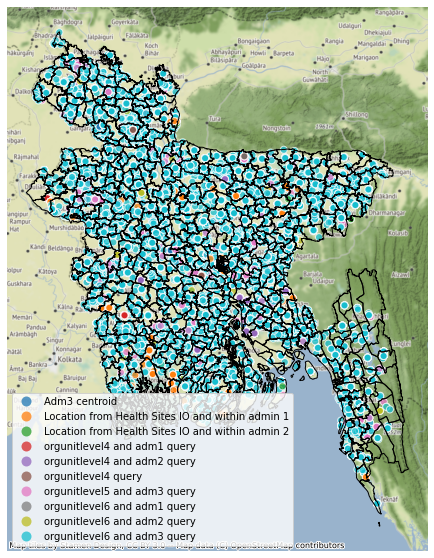

In [136]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
geob3.boundary.plot(ax=ax, color='black', linewidth=1).set_axis_off()
results.loc[results.geocoding_method!="None"].plot(ax=ax, column='geocoding_method', edgecolor='white', markersize=50, alpha=0.75, legend=True)
ctx.add_basemap(ax, source=ctx.providers.Stamen.Terrain, crs='EPSG:4326', zorder=-10)

## Join attributes from adminsitrative polygons

Join admin data back to results.  
For adm3 features, use spatial join to geob3.  

In [137]:
results2 = results.loc[~(results.longitude.isna())].copy()

In [138]:
records_subset = records.loc[records.geocoding_method=="None"].copy()

In [139]:
len(records_subset)

0

In [140]:
results2 = gpd.sjoin(results2, geob3[["shapeName", "shapeID", "geometry"]], how='left', predicate='intersects')
results2.drop('index_right', axis=1, inplace=True)

In [141]:
results2.rename(
    columns={
        'shapeName':'geob_adm3',
        'shapeID':'geob_adm3_id',
    }, inplace=True)

In [142]:
results2 = gpd.sjoin(results2, geob2[["shapeName", "shapeID", "geometry"]], how='left', predicate='intersects')
results2.drop('index_right', axis=1, inplace=True)

In [143]:
results2.rename(
    columns={
        'shapeName':'geob_adm2',
        'shapeID':'geob_adm2_id',
    }, inplace=True)

In [144]:
results2 = gpd.sjoin(results2, geob1[["shapeName", "shapeID", "geometry"]], how='left', predicate='intersects')
results2.drop('index_right', axis=1, inplace=True)

In [145]:
results2.rename(
    columns={
        'shapeName':'geob_adm1',
        'shapeID':'geob_adm1_id',
    }, inplace=True)

In [146]:
results2.geob_adm3.isna().sum(), results2.geob_adm2.isna().sum(), results2.geob_adm1.isna().sum()

(0, 0, 119)

In [149]:
results2.rename(
    columns={
        'adm1':'fuzzy_match_adm1',
        'adm2':'fuzzy_match_adm2',
        'adm3':'fuzzy_match_adm3'
    }, inplace=True)

In [150]:
results_final = results2.copy()

In [151]:
# results_final = pd.concat([results2, records_subset])
# results_final.sort_index(inplace=True)

results_final.to_csv(join(output_dir, "BGD_geocoding_1.24.23.csv"))
results_final.to_file(join(output_dir, "BGD_geocoding_1.24.23.json"), driver="GeoJSON")